<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4

## Help Yelp

---

In this project you will be investigating a small version of the [Yelp challenge dataset](https://www.yelp.com/dataset_challenge). You'll practice using classification algorithms, cross-validation, gridsearching – all that good stuff.



---

### The data

There are 5 individual .csv files that have the information, zipped into .7z format like with the SF data last project. The dataset is located in your datasets folder:

    DSI-SF-2/datasets/yelp_arizona_data.7z

The columns in each are:

    businesses_small_parsed.csv
        business_id: unique business identifier
        name: name of the business
        review_count: number of reviews per business
        city: city business resides in
        stars: average rating
        categories: categories the business falls into (can be one or multiple)
        latitude
        longitude
        neighborhoods: neighborhoods business belongs to
        variable: "property" of the business (a tag)
        value: True/False for the property
        
    reviews_small_nlp_parsed.csv
        user_id: unique user identifier
        review_id: unique review identifier
        votes.cool: how many thought the review was "cool"
        business_id: unique business id the review is for
        votes.funny: how many thought the review was funny
        stars: rating given
        date: date of review
        votes.useful: how many thought the review was useful
        ... 100 columns of counts of most common 2 word phrases that appear in reviews in this review
        
    users_small_parsed.csv
        yelping_since: signup date
        compliments.plain: # of compliments "plain"
        review_count: # of reviews:
        compliments.cute: total # of compliments "cute"
        compliments.writer: # of compliments "writer"
        compliments.note: # of compliments "note" (not sure what this is)
        compliments.hot: # of compliments "hot" (?)
        compliments.cool: # of compliments "cool"
        compliments.profile: # of compliments "profile"
        average_stars: average rating
        compliments.more: # of compliments "more"
        elite: years considered "elite"
        name: user's name
        user_id: unique user id
        votes.cool: # of votes "cool"
        compliments.list: # of compliments "list"
        votes.funny: # of compliments "funny"
        compliments.photos: # of compliments "photos"
        compliments.funny: # of compliments "funny"
        votes.useful: # of votes "useful"
       
    checkins_small_parsed.csv
        business_id: unique business identifier
        variable: day-time identifier of checkins (0-0 is Sunday 0:00 - 1:00am,  for example)
        value: # of checkins at that time
    
    tips_small_nlp_parsed.csv
        user_id: unique user identifier
        business_id: unique business identifier
        likes: likes that the tip has
        date: date of tip
        ... 100 columns of counts of most common 2 word phrases that appear in tips in this tip

The reviews and tips datasets in particular have parsed "NLP" columns with counts of 2-word phrases in that review or tip (a "tip", it seems, is some kind of smaller review).

The user dataset has a lot of columns of counts of different compliments and votes. I'm not sure whether the compliments or votes are _by_ the user or _for_ the user.

---

If you look at the website, or the full data, you'll see I have removed pieces of the data and cut it down quite a bit. This is to simplify it for this project. Specifically, business are limited to be in these cities:

    Phoenix
    Surprise
    Las Vegas
    Waterloo

Apparently there is a city called "Surprise" in Arizona. 

Businesses are also restricted to at least be in one of the following categories, because I thought the mix of them was funny:

    Airports
    Breakfast & Brunch
    Bubble Tea
    Burgers
    Bars
    Bakeries
    Breweries
    Cafes
    Candy Stores
    Comedy Clubs
    Courthouses
    Dance Clubs
    Fast Food
    Museums
    Tattoo
    Vape Shops
    Yoga
    
---

### Project requirements

**You will be performing 4 different sections of analysis, like in the last project.**

Remember that classification targets are categorical and regression targets are continuous variables.

In [1]:
import pandas as pd
import numpy as np
import patsy
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.grid_search import GridSearchCV

% matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Constructing a "profile" for Las Vegas

---

Yelp is interested in building out what they are calling "profiles" for cities. They want you to start with just Las Vegas to see what a prototype of this would look like. Essentially, they want to know what makes Las Vegas distinct from the other four.

Use the data you have to predict Las Vegas from the other variables you have. You should not be predicting the city from any kind of location data or other data perfectly associated with that city (or another city).

You may use any classification algorithm you deem appropriate, or even multiple models. You should:

1. Build at least one model predicting Las Vegas vs. the other cities.
- Validate your model(s).
- Interpret and visualize, in some way, the results.
- Write up a "profile" for Las Vegas. This should be a writeup converting your findings from the model(s) into a human-readable description of the city.

In [2]:
#Loading data from the arizona dataset
business = pd.read_csv('yelp_arizona_data/businesses_small_parsed.csv')
checkins = pd.read_csv('yelp_arizona_data/checkins_small_parsed.csv')
reviews = pd.read_csv('yelp_arizona_data/reviews_small_nlp_parsed.csv')
tips = pd.read_csv('yelp_arizona_data/tips_small_nlp_parsed.csv')
users = pd.read_csv('yelp_arizona_data/users_small_parsed.csv')

In [3]:
#Dropping the data columns related to the city(neighboorhoods, latitude, and longitude)
business.drop(['neighborhoods', 'latitude', 'longitude'], axis=1, inplace=True)
business.head(2)

,business_id,name,review_count,city,stars,categories,variable,value
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"['American (New)', 'Nightlife', 'Dance Clubs',...",attributes.Ambience.divey,False
1,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,"['Bars', 'Nightlife', 'Dance Clubs']",attributes.Ambience.divey,False


In [4]:
#Simple EDA
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152832 entries, 0 to 152831
Data columns (total 8 columns):
business_id     152832 non-null object
name            152832 non-null object
review_count    152832 non-null int64
city            152832 non-null object
stars           152832 non-null float64
categories      152832 non-null object
variable        152832 non-null object
value           152832 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 9.3+ MB


In [6]:
#Taking the table and pivoting it to a wide format.
#This is done by taking the variable as the column, and the index as business_id.

def select_item_or_nan(x):
    x = x.iloc[0]
    if len(x) == 0:
        return np.nan
    else:
        return x
    
business_wide = pd.pivot_table(business, columns=['variable'], values='value',
                                     index=['business_id'], aggfunc=select_item_or_nan,
                                     fill_value=0)

In [7]:
business_wide.head(2)

#Remove the period and blank space in the column name replace with _
business_wide.columns = [x.strip().replace(' ', '_') for x in business_wide.columns]
business_wide.columns = [x.strip().replace('.', '_') for x in business_wide.columns]

In [8]:
business_wide = business_wide.reset_index() #Reset the indexes

In [9]:
#Merge the business table with the wide table on business id
business_final = pd.merge(business, business_wide, on = 'business_id', how='left')

In [10]:
business_final.head(2)

,business_id,name,review_count,city,stars,categories,variable,value,attributes_Accepts_Credit_Cards,attributes_Accepts_Insurance,...,hours_Saturday_open,hours_Sunday_close,hours_Sunday_open,hours_Thursday_close,hours_Thursday_open,hours_Tuesday_close,hours_Tuesday_open,hours_Wednesday_close,hours_Wednesday_open,open
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"['American (New)', 'Nightlife', 'Dance Clubs',...",attributes.Ambience.divey,False,True,0,...,09:00,03:00,09:00,03:00,09:00,0,0,0,0,True
1,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,"['Bars', 'Nightlife', 'Dance Clubs']",attributes.Ambience.divey,False,True,0,...,0,0,0,0,0,0,0,0,0,True


In [11]:
#I plan on looking at the variables I feel would work well with Las Vegas
#Ex: alcohol, upscale.
business_final['attributes_Alcohol']
business_final['attributes_Alcohol'] = business_final['attributes_Alcohol'].map(lambda x: 0 if x == 'none' else 1)

In [12]:
business_final['attributes_Ambience_upscale'] = business_final['attributes_Ambience_upscale'].map(lambda x: 0 if x == 'False' else 1)

In [13]:
business_final['attributes_Accepts_Credit_Cards'] = business_final['attributes_Accepts_Credit_Cards'].map(lambda x: 0 if x == 'False' else 1)

In [14]:
#Creating binary values for the different cities will use them to design 4 models for each city..
business_final['vegas'] = business_final['city'].map(lambda x: 1 if x == 'Las Vegas' else 0)
business_final['water'] = business_final['city'].map(lambda x: 1 if x == 'Waterloo' else 0)
business_final['phoe'] = business_final['city'].map(lambda x: 1 if x == 'Phoenix' else 0)
business_final['surprise'] = business_final['city'].map(lambda x: 1 if x == 'Surprise' else 0)

In [15]:
business_final.head(2)

,business_id,name,review_count,city,stars,categories,variable,value,attributes_Accepts_Credit_Cards,attributes_Accepts_Insurance,...,hours_Thursday_open,hours_Tuesday_close,hours_Tuesday_open,hours_Wednesday_close,hours_Wednesday_open,open,vegas,water,phoe,surprise
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"['American (New)', 'Nightlife', 'Dance Clubs',...",attributes.Ambience.divey,False,1,0,...,09:00,0,0,0,0,True,0,0,1,0
1,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,"['Bars', 'Nightlife', 'Dance Clubs']",attributes.Ambience.divey,False,1,0,...,0,0,0,0,0,True,0,0,1,0


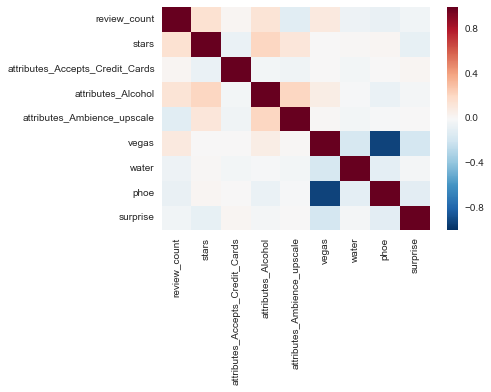

In [18]:
sns.heatmap(business_final.corr())

In [16]:
#Im setting the predictor variables to be the Alcohol, Ambience_upscale, and Accepts_Credit_Cards
X = business_final[['attributes_Alcohol', 'attributes_Ambience_upscale', 'attributes_Accepts_Credit_Cards']]
y = business_final['vegas'].values
y2 = business_final['water'].values
y3 = business_final['phoe'].values
y4 = business_final['surprise'].values

In [19]:
#Train/Test split by 60:40
X_veg_train, X_veg_test, y_veg_train, y_veg_test = train_test_split(X, y, test_size=0.4)
X_wat_train, X_wat_test, y_wat_train, y_wat_test = train_test_split(X, y2, test_size=0.4)
X_pho_train, X_pho_test, y_pho_train, y_pho_test = train_test_split(X, y3, test_size=0.4)
X_sur_train, X_sur_test, y_sur_train, y_sur_test = train_test_split(X, y4, test_size=0.4)

In [20]:
lr_params = {
    'solver':['liblinear'],
    'penalty':['l2','l1'],
    'C':range(1, 5, 1)
}

veg_gs = GridSearchCV(LogisticRegression(), lr_params, cv=10, verbose=1)
wat_gs = GridSearchCV(LogisticRegression(), lr_params, cv=10, verbose=1)
pho_gs = GridSearchCV(LogisticRegression(), lr_params, cv=10, verbose=1)
sur_gs = GridSearchCV(LogisticRegression(), lr_params, cv=10, verbose=1)

veg_gs.fit(X_veg_train, y_veg_train)
wat_gs.fit(X_wat_train, y_wat_train)
pho_gs.fit(X_pho_train, y_pho_train)
sur_gs.fit(X_sur_train, y_sur_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   12.3s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   24.4s finished


Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   12.0s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   20.2s finished


Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   12.2s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   24.5s finished


Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  1.5min
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  3.6min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l2', 'l1'], 'C': [1, 2, 3, 4], 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [21]:
#Taking the score and the ideal parameters for each city.
veg_lr = veg_gs.best_estimator_
print "Params and Score for Vegas"
print veg_gs.best_params_
print veg_gs.best_score_, np.abs(0.5 - np.mean(y_veg_train)) + 0.5
print ""
print "Params and Score for Waterloo"
wat_lr = wat_gs.best_estimator_
print wat_gs.best_params_
print wat_gs.best_score_, np.abs(0.5 - np.mean(y_wat_train)) + 0.5
print ""
print "Params and Score for Phoenix"
pho_lr = pho_gs.best_estimator_
print pho_gs.best_params_
print pho_gs.best_score_, np.abs(0.5 - np.mean(y_pho_train)) + 0.5
print ""
print "Params and Score for Surprise"
sur_lr = sur_gs.best_estimator_
print sur_gs.best_params_
print sur_gs.best_score_, np.abs(0.5 - np.mean(y_sur_train)) + 0.5

Params and Score for Vegas
{'penalty': 'l2', 'C': 1, 'solver': 'liblinear'}
0.614325128955 0.614325128955

Params and Score for Waterloo
{'penalty': 'l2', 'C': 1, 'solver': 'liblinear'}
0.982039062585 0.982039062585

Params and Score for Phoenix
{'penalty': 'l2', 'C': 1, 'solver': 'liblinear'}
0.649941656943 0.649941656943

Params and Score for Surprise
{'penalty': 'l2', 'C': 1, 'solver': 'liblinear'}
0.980555949356 0.980555949356


In [22]:
#Based on the score values of 0.61 for Vegas, 0.982 for Waterloo, 0.65 for Phoenix, and 0.980 for Surprise
#We can say the models fit the data well. Both Waterloo and Surprise have the best models, while Vegas and
#and Phoenix have moderate models.

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
#Function to plot the ROC will call the function for each city.
def plot_roc(mod, X, y, varname):
    mod.fit(X, y)
    y_pp = mod.predict_proba(X)[:, 1]
    fpr_, tpr_, _ = roc_curve(y, y_pp)
    auc_ = auc(fpr_, tpr_)
    acc_ = np.abs(0.5 - np.mean(y)) + 0.5
    
    fig, axr = plt.subplots(figsize=(8,7))

    axr.plot(fpr_, tpr_, label='ROC (area = %0.2f)' % auc_,
             color='darkred', linewidth=4,
             alpha=0.7)
    axr.plot([0, 1], [0, 1], color='grey', ls='dashed',
             alpha=0.9, linewidth=4, label='baseline accuracy = %0.2f' % acc_)

    axr.set_xlim([-0.05, 1.05])
    axr.set_ylim([0.0, 1.05])
    axr.set_xlabel('false positive rate', fontsize=16)
    axr.set_ylabel('true positive rate', fontsize=16)
    axr.set_title(varname+' vs. not ROC curve\n', fontsize=20)

    axr.legend(loc="lower right", fontsize=12)

    plt.show()

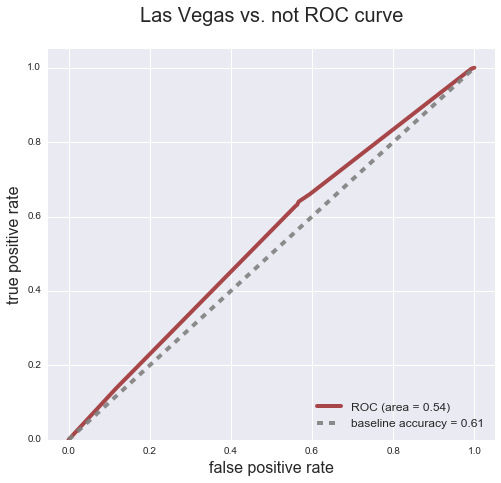

In [24]:
#Plotting ROC curve for Las Vegas
plot_roc(veg_lr, X_veg_test, y_veg_test, 'Las Vegas')

In [ ]:
#The Vegas ROC has a ROC (AUC) of 0.53 which shows the model is average.
#The average accuracy of getting Vegas is 0.61

#The results are surprising considering Vegas is bar and ambience filled location. 
#There is a chance that most locations in Vegas don't take credit card.

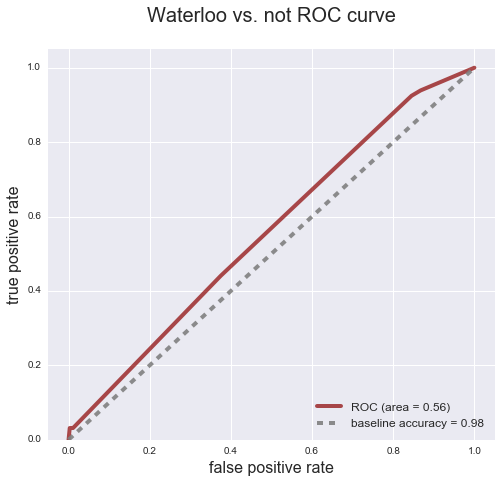

In [25]:
#Plotting ROC curve for Waterloo
plot_roc(wat_lr, X_wat_test, y_wat_test, 'Waterloo')

In [ ]:
#The ROC and baseline accuracy is slightly better than Vegas

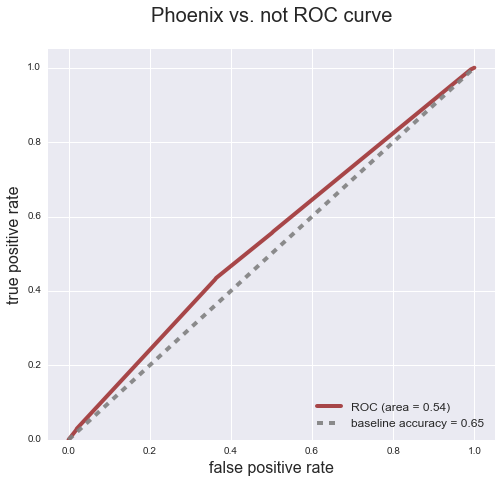

In [26]:
#Plotting ROC curve for Phoenix
plot_roc(pho_lr, X_pho_test, y_pho_test, 'Phoenix')

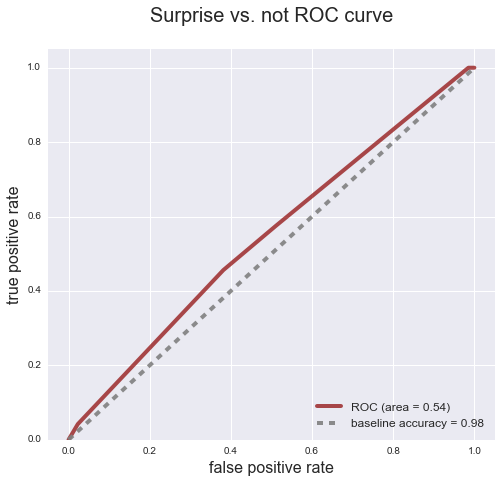

In [27]:
#Plotting ROC curve for Surprise
plot_roc(sur_lr, X_sur_test, y_sur_test, 'Surprise')

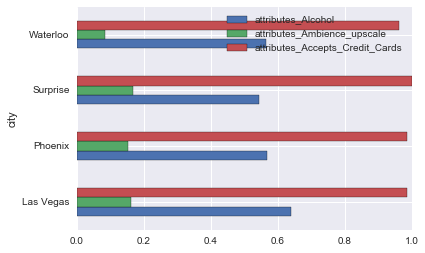

In [28]:
business_final.groupby('city')[['attributes_Alcohol', 'attributes_Ambience_upscale', 'attributes_Accepts_Credit_Cards']].mean().plot(kind = 'barh')

In [29]:
business_final.corr().T

,review_count,stars,attributes_Accepts_Credit_Cards,attributes_Alcohol,attributes_Ambience_upscale,vegas,water,phoe,surprise
review_count,1.000000,0.153375,0.019736,0.138445,-0.114046,0.096229,-0.050366,-0.073418,-0.037326
stars,0.153375,1.000000,-0.064408,0.213839,0.121785,0.004952,0.008593,0.016666,-0.083235
attributes_Accepts_Credit_Cards,0.019736,-0.064408,1.000000,-0.030269,-0.043352,0.002229,-0.026684,0.000191,0.017212
attributes_Alcohol,0.138445,0.213839,-0.030269,1.000000,0.213210,0.073443,-0.013024,-0.065626,-0.019904
attributes_Ambience_upscale,-0.114046,0.121785,-0.043352,0.213210,1.000000,0.014770,-0.027564,-0.008522,0.003919
vegas,0.096229,0.004952,0.002229,0.073443,0.014770,1.000000,-0.171021,-0.922394,-0.177622
water,-0.050366,0.008593,-0.026684,-0.013024,-0.027564,-0.171021,1.000000,-0.099228,-0.019108
phoe,-0.073418,0.016666,0.000191,-0.065626,-0.008522,-0.922394,-0.099228,1.000000,-0.103058
surprise,-0.037326,-0.083235,0.017212,-0.019904,0.003919,-0.177622,-0.019108,-0.103058,1.000000


In [ ]:
#Based on our model we can say, Alcohol, Ambience, and Credit Cards don't affect the city (Las Vegas) as 
#much as we would have expected. Surprisingly Waterloo is affeceted the most by these conditions. There are
#probably other conditions that might affect the city. 

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Different categories of ratings

---

Yelp is finally ready to admit that their rating system sucks. No one cares about the ratings, they just use the site to find out what's nearby. The ratings are simply too unreliable for people. 

Yelp hypothesizes that this is, in fact, because different people tend to give their ratings based on different things. They believe that perhaps some people always base their ratings on quality of food, others on service, and perhaps other categories as well. 

1. Do some users tend to talk about service more than others in reviews/tips? Divide up the tips/reviews into more "service-focused" ones and those less concerned with service.
2. Create two new ratings for businesses: ratings from just the service-focused reviews and ratings from the non-service reviews.
3. Construct a regression model for each of the two ratings. They should use the same predictor variables (of your choice). 
4. Validate the performance of the models.
5. Do the models coefficients differ at all? What does this tell you about the hypothesis that there are in fact two different kinds of ratings?

In [108]:
tips_group = tips.groupby(['user_id']).mean()
#I plan on merging the tips dataframe with the service dataframe on user_id.

In [109]:
tips_group = tips_group.reset_index()

In [110]:
tips_group.head(2)

,user_id,likes,24 hours,amazing food,animal style,awesome food,awesome place,awesome service,beef hash,beer selection,...,service good,service great,slow service,staff friendly,staff great,steak eggs,super friendly,sweet potato,velvet pancakes,worth wait
0,--2QZsyXGz1OhiD4-0FQLQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,--4fX3LBeXoE88gDTK6TKQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
reviews_group = reviews.groupby(['user_id']).mean()

In [112]:
reviews_group = reviews_group.reset_index()

In [113]:
reviews_group.head(2)

,user_id,votes.cool,votes.funny,stars,votes.useful,10 minutes,15 minutes,20 minutes,30 minutes,bar food,...,service great,staff friendly,super friendly,sweet potato,tasted like,time vegas,try place,ve seen,ve tried,wait staff
0,--0HEXd4W6bJI8k7E0RxTA,1.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,--2QZsyXGz1OhiD4-0FQLQ,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
service = pd.merge(reviews_group, tips_group, on = 'user_id', how = 'left')
#Merge the tables together.

In [115]:
service_df = service.filter(regex = 'service|staff|friendly|stars|elite')
#I used the filter by regex to return the columns and values in the column based on the character.

In [116]:
column = service.columns - service_df.columns
#Find the difference between the dataframe columns

/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  if __name__ == '__main__':


In [117]:
nonservice_df = service[column]

In [118]:
service_df = service_df.fillna(0)
nonservice_df = nonservice_df.fillna(0)

In [119]:
nonservice_df['stars'] = service_df['stars']

In [120]:
nonservice_df.columns = [x.strip().replace(' ', '_') for x in nonservice_df.columns]
nonservice_df.columns = [x.strip().replace('.', '_') for x in nonservice_df.columns]
service_df.columns = [x.strip().replace(' ', '_') for x in service_df.columns]

In [121]:
nonservice_df.shape, service_df.shape

((144206, 174), (144206, 33))

In [122]:
dup = nonservice_df.filter(regex = '_y')
nonservice_df.drop(dup, axis=1, inplace=True)
dup2 = service_df.filter(regex = '_y')
service_df.drop(dup2, axis = 1, inplace=True)
#Removing the duplicated columns, that arise from merging the tables.

In [124]:
nonservice_df.head(2)

,10_minutes,15_minutes,20_minutes,24_hours,30_minutes,amazing_food,animal_style,awesome_food,awesome_place,bar_food,...,try_place,user_id,ve_seen,ve_tried,velvet_pancakes,votes_cool,votes_funny,votes_useful,worth_wait,stars
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,--0HEXd4W6bJI8k7E0RxTA,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,--2QZsyXGz1OhiD4-0FQLQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [125]:
service_df.head(2)

,stars,bottle_service_x,customer_service_x,food_service_x,friendly_staff_x,good_service_x,great_service_x,service_excellent,service_food_x,service_friendly,...,staff_friendly_x,super_friendly_x,wait_staff,awesome_service,excellent_service,fast_service,friendly_service,great_staff,slow_service,staff_great
0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
X = nonservice_df[['friday_night', 'recommend_place']]
y = nonservice_df['stars'].values
X2 = service_df[['service_good_x', 'service_friendly']]
y2 = service_df['stars'].values
#Use a continuous variable in this case average stars

In [127]:
X_nser_train, X_nser_test, y_nser_train, y_nser_test = train_test_split(X, y,test_size=0.4)
X_ser_train, X_ser_test, y_ser_train, y_ser_test = train_test_split(X2, y2,test_size=0.4)

print X_nser_train.shape, X_nser_test.shape, y_nser_train.shape, y_nser_test.shape
print X_ser_train.shape, X_ser_test.shape, y_ser_train.shape, y_ser_test.shape

(86523, 2) (57683, 2) (86523,) (57683,)
(86523, 2) (57683, 2) (86523,) (57683,)


In [128]:
lm = LinearRegression() #Using linear regression since y is a continous value.

model_nser = lm.fit(X, y)
model_ser = lm.fit(X2,y2)
predictions_nser = lm.predict(X)
predictions_ser = lm.predict(X2)

print "Mean of predictions for Nonservice & Service"
print predictions_nser.mean()
print predictions_ser.mean()
print ""
print "Score for Nonservice & Service"
print model_nser.score(X, y)
print model_ser.score(X2, y2)
print ""
print "Coefficient for Nonservice & Service"
print model_nser.coef_
print model_ser.coef_
print ""
print "Intercept"
print lm.intercept_

Mean of predictions for Nonservice & Service
3.75062961863
3.74617045351

Score for Nonservice & Service
0.000260822824375
0.000637845602973

Coefficient for Nonservice & Service
[-0.10308448  0.43139115]
[-0.10308448  0.43139115]

Intercept
3.74502839051


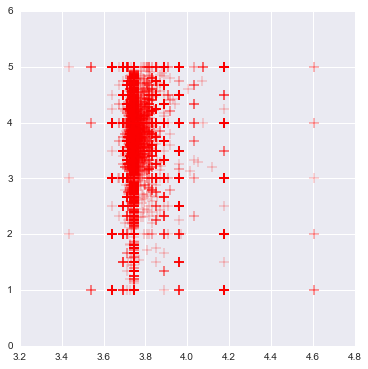

In [129]:
fig = plt.figure(figsize=(6,6))
plt.scatter(predictions_nser, y, s=100, c='r', marker='+')

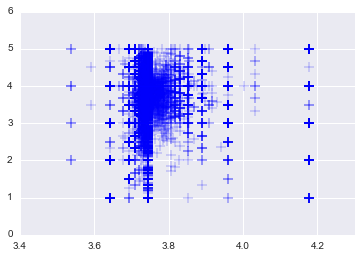

In [130]:
plt.scatter(predictions_ser, y2, s=100, c='b', marker='+')

In [ ]:
#The coefficients and visualization for the service and nonservice models are similar. 
#We can reject the hypothesis that there is two different kinds of ratings.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Identifying "elite" users

---

Yelp, though having their own formula for determining whether a user is elite or not, is interested in delving deeper into what differentiates an elite user from a normal user at a broader level.

Use a classification model to predict whether a user is elite or not. Note that users can be elite in some years and not in others.

1. What things predict well whether a user is elite or not?
- Validate the model.
- If you were to remove the "counts" metrics for users (reviews, votes, compliments), what distinguishes an elite user, if anything? Validate the model and compare it to the one with the count variables.
- Think of a way to visually represent your results in a compelling way.
- Give a brief write-up of your findings.


In [ ]:
#The popularity of the user, as in the votes, compliments and contribution affect whether the user
#is elite or not. There are multiple users that elite in one or some years.

In [48]:
users = pd.read_csv('yelp_arizona_data/users_small_parsed.csv')

In [49]:
users_info = users.groupby('user_id')[['yelping_since', 'elite']].max()

In [50]:
users_info = users_info.reset_index()

In [51]:
users_info['year'] = users_info['yelping_since'].str[:4]
#Going to look into an empty list and set to 0 for elite else 1

In [52]:
users_info['elite'] = users_info['elite'].map(lambda x: 0 if x == '[]' else 1)

In [53]:
users.drop(['yelping_since', 'elite'], axis=1, inplace=True)

In [54]:
elite_df = pd.merge(users, users_info, on = 'user_id', how = 'left')

In [55]:
elite_df = elite_df.fillna(0)

In [56]:
elite_comp = elite_df.filter(regex = 'review|vote|complimen|elite')
#Take the count type of dataframe.

In [57]:
elite_comp.head(2)

,compliments.plain,review_count,compliments.cute,compliments.writer,compliments.note,compliments.hot,compliments.cool,compliments.profile,compliments.more,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful,elite
0,959.0,1274,206.0,327.0,611.0,1094.0,1642.0,116.0,134.0,11093,38.0,7681,330.0,580.0,14199,1
1,89.0,442,23.0,24.0,83.0,101.0,145.0,9.0,19.0,732,4.0,908,24.0,120.0,1483,1


In [58]:
column = elite_df.columns - elite_comp.columns

/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  if __name__ == '__main__':


In [59]:
elite_ncomp = elite_df[column]

In [60]:
elite_ncomp['elite'] = elite_comp['elite']

/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [61]:
elite_comp.columns = [x.strip().replace('.', '_') for x in elite_comp.columns]

In [62]:
elite_ncomp.head(2)

,average_stars,fans,name,user_id,year,yelping_since,elite
0,3.66,1179,Jeremy,rpOyqD_893cqmDAtJLbdog,2004,2004-10,1
1,3.60,100,Michael,4U9kSBLuBDU391x6bxU-YA,2004,2004-10,1


In [63]:
elite_comp.head(2)

,compliments_plain,review_count,compliments_cute,compliments_writer,compliments_note,compliments_hot,compliments_cool,compliments_profile,compliments_more,votes_cool,compliments_list,votes_funny,compliments_photos,compliments_funny,votes_useful,elite
0,959.0,1274,206.0,327.0,611.0,1094.0,1642.0,116.0,134.0,11093,38.0,7681,330.0,580.0,14199,1
1,89.0,442,23.0,24.0,83.0,101.0,145.0,9.0,19.0,732,4.0,908,24.0,120.0,1483,1


In [64]:
X = elite_comp[['compliments_plain', 'votes_useful', 'compliments_cool']]
y = elite_comp['elite'].values
X2 = elite_ncomp[['average_stars', 'fans']]
y2 = elite_ncomp['elite'].values

In [ ]:
#For the non compliment dataframe I'm going to look into the number of fans, and average stars received.
#Realistically the higher the average_stars and fans the stronger the model should be.

In [65]:
X_ncomp_train, X_ncomp_test, y_ncomp_train, y_ncomp_test = train_test_split(X, y,test_size=0.4)
X_comp_train, X_comp_test, y_comp_train, y_comp_test = train_test_split(X2, y2,test_size=0.4)

print X_ncomp_train.shape, X_ncomp_test.shape, y_ncomp_train.shape, y_ncomp_test.shape
print X_comp_train.shape, X_comp_test.shape, y_comp_train.shape, y_comp_test.shape

(86523, 3) (57683, 3) (86523,) (57683,)
(86523, 2) (57683, 2) (86523,) (57683,)


In [66]:
lr_params = {
    'solver':['liblinear'],
    'penalty':['l2','l1'],
    'C':range(1, 5, 1)
}

ncomp_gs = GridSearchCV(LogisticRegression(), lr_params, cv=10, verbose=1)
comp_gs = GridSearchCV(LogisticRegression(), lr_params, cv=10, verbose=1)


ncomp_gs.fit(X_ncomp_train, y_ncomp_train)
comp_gs.fit(X_comp_train, y_comp_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   34.1s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   49.8s finished


Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   12.7s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   22.9s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l2', 'l1'], 'C': [1, 2, 3, 4], 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [67]:
ncomp_lr = ncomp_gs.best_estimator_
print "Params and Score for Non Count Variables"
print ncomp_gs.best_params_
print ncomp_gs.best_score_, np.abs(0.5 - np.mean(y_ncomp_train)) + 0.5
print ""
print "Params and Score for Count Variables"
comp_lr = comp_gs.best_estimator_
print comp_gs.best_params_
print comp_gs.best_score_, np.abs(0.5 - np.mean(y_comp_train)) + 0.5

Params and Score for Non Count Variables
{'penalty': 'l1', 'C': 1, 'solver': 'liblinear'}
0.941345075876 0.885833824532

Params and Score for Count Variables
{'penalty': 'l2', 'C': 1, 'solver': 'liblinear'}
0.935231094622 0.884319776244


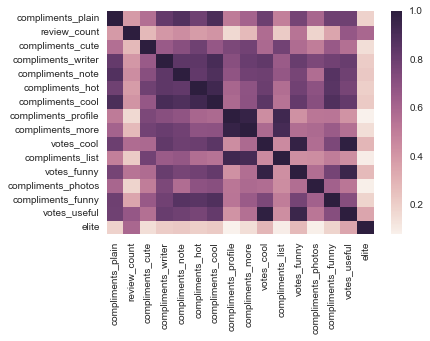

In [70]:
sns.heatmap(elite_comp.corr())

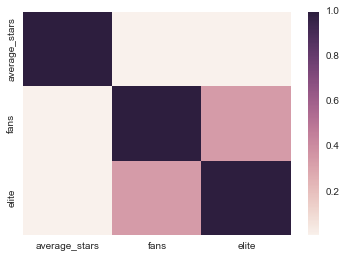

In [71]:
sns.heatmap(elite_ncomp.corr())

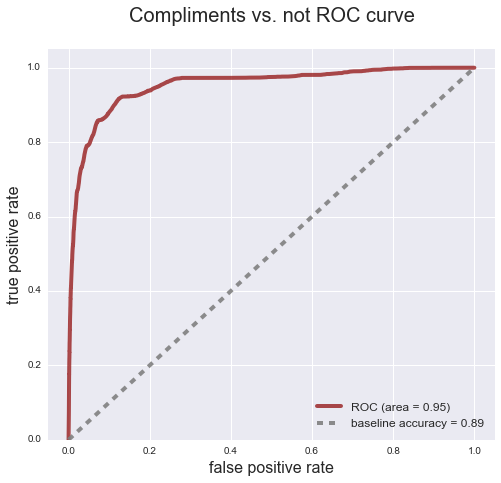

In [68]:
plot_roc(comp_lr, X_comp_test, y_comp_test, 'Compliments')

In [132]:
model_comp = lm.fit(X, y)
predictions_comp = lm.predict(X)

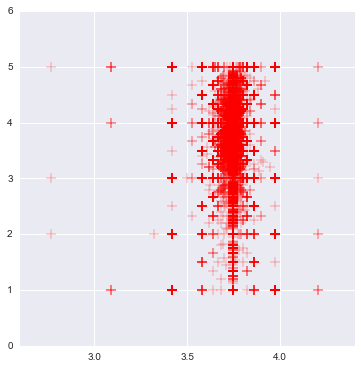

In [133]:
fig = plt.figure(figsize=(6,6))
plt.scatter(predictions_comp, y, s=100, c='r', marker='+')

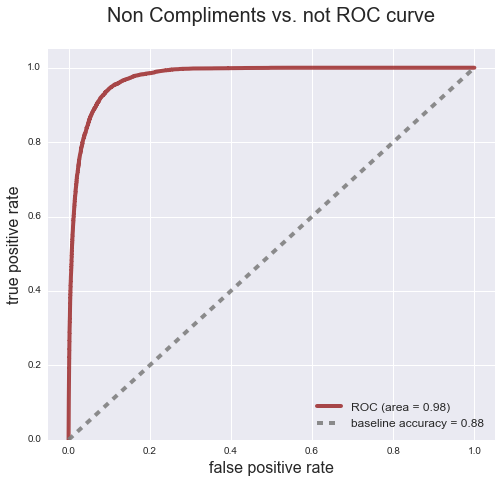

In [69]:
plot_roc(ncomp_lr, X_ncomp_test, y_ncomp_test, 'Non Compliments')

In [134]:
model_ncomp = lm.fit(X2,y2)
predictions_ncomp= lm.predict(X2)

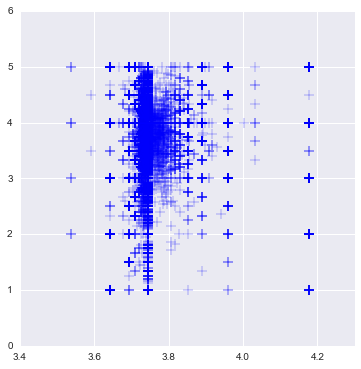

In [136]:
fig = plt.figure(figsize=(6,6))
plt.scatter(predictions_ncomp, y2, s=100, c='b', marker='+')

In [72]:
#There isn't much difference between the count metric and non count metrics.
#Based on the area the value is very similar and accurate.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Find something interesting on your own

---

You want to impress your superiors at Yelp by doing some investigation into the data on your own. You want to do classification, but you're not sure on what.

1. Create a hypothesis or hypotheses about the data based on whatever you are interested in, as long as it is predicting a category of some kind (classification).
2. Explore the data visually (ideally related to this hypothesis).
3. Build one or more classification models to predict your target variable. **Your modeling should include gridsearching to find optimal model parameters.**
4. Evaluate the performance of your model. Explain why your model may have chosen those specific parameters during the gridsearch process.
5. Write up what the model tells you. Does it validate or invalidate your hypothesis? Write this up as if for a non-technical audience.

In [73]:
users.head(2)

,compliments.plain,review_count,compliments.cute,compliments.writer,fans,compliments.note,compliments.hot,compliments.cool,compliments.profile,average_stars,compliments.more,name,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful
0,959.0,1274,206.0,327.0,1179,611.0,1094.0,1642.0,116.0,3.66,134.0,Jeremy,rpOyqD_893cqmDAtJLbdog,11093,38.0,7681,330.0,580.0,14199
1,89.0,442,23.0,24.0,100,83.0,101.0,145.0,9.0,3.60,19.0,Michael,4U9kSBLuBDU391x6bxU-YA,732,4.0,908,24.0,120.0,1483


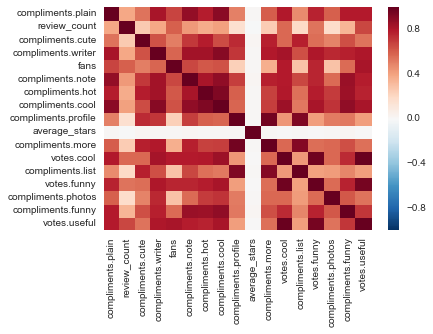

In [74]:
#There is a high relationship between the type of contribution(compliment, vote) and the stars.
sns.heatmap(users.corr())

In [75]:
users['round_stars'] = users['average_stars'].round()

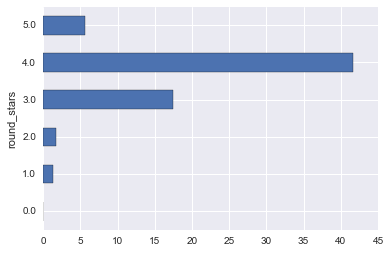

In [76]:
users.groupby('round_stars')['compliments.plain'].mean().plot(kind = 'barh')

In [77]:
users['star'] = users['round_stars'].map(lambda x: 1 if x > 2 else 0)

In [78]:
users.columns = [x.strip().replace('.', '_') for x in users.columns]

In [79]:
users = users.fillna(0)

In [80]:
X = users[['compliments_plain', 'compliments_cute', 'compliments_writer', 'compliments_note', 'compliments_hot', 'compliments_cool', 'compliments_profile', 'compliments_more', 'compliments_list', 'compliments_photos', 'compliments_funny']].head(1000)
X2 = users[['votes_cool','votes_funny', 'votes_useful']].head(1000)
y = users['star'].head(1000).values

In [81]:
users.shape

(144206, 21)

In [82]:
X_comp_train, X_comp_test, y_comp_train, y_comp_test = train_test_split(X, y,test_size=0.4)
X_vote_train, X_vote_test, y_vote_train, y_vote_test = train_test_split(X2, y,test_size=0.4)

In [83]:
lr_params = {
    'solver':['liblinear'],
    'penalty':['l2','l1'],
    'C':range(1, 5, 1)
}

comp_gs = GridSearchCV(LogisticRegression(), lr_params, cv=10, verbose=1)
vote_gs = GridSearchCV(LogisticRegression(), lr_params, cv=10, verbose=1)

comp_gs.fit(X_comp_train, y_comp_train)
vote_gs.fit(X_vote_train, y_vote_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    7.0s finished


Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    8.0s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l2', 'l1'], 'C': [1, 2, 3, 4], 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [84]:
comp_lr = comp_gs.best_estimator_
print comp_gs.best_params_
print comp_gs.best_score_, np.abs(0.5 - np.mean(y_comp_train)) + 0.5

vote_lr = vote_gs.best_estimator_
print vote_gs.best_params_
print vote_gs.best_score_, np.abs(0.5 - np.mean(y_vote_train)) + 0.5

{'penalty': 'l2', 'C': 1, 'solver': 'liblinear'}
0.935 0.935
{'penalty': 'l1', 'C': 1, 'solver': 'liblinear'}
0.935 0.936666666667


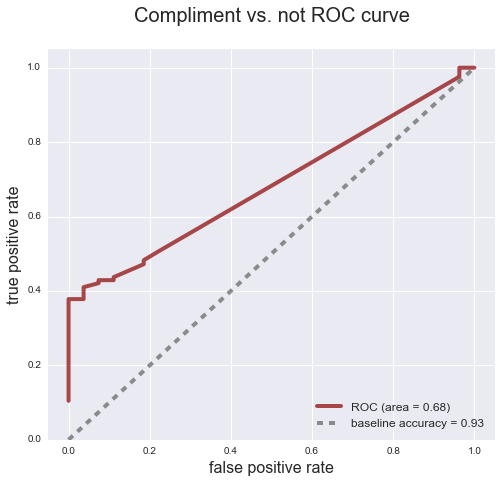

In [85]:
plot_roc(comp_lr, X_comp_test, y_comp_test, 'Compliment')

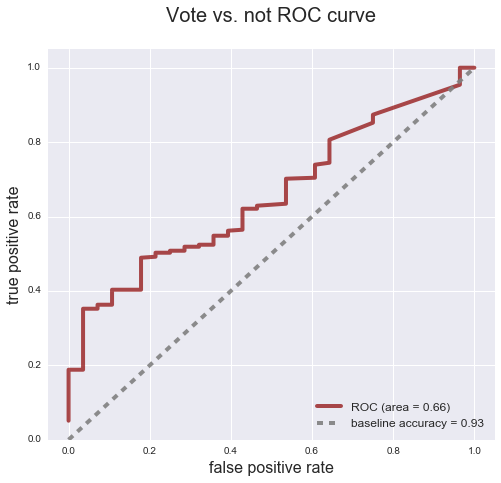

In [86]:
plot_roc(vote_lr, X_vote_test, y_vote_test, 'Vote')

In [ ]:
#There isn't much difference between the type of contribution and the stars.
#There is an extremely minor advantage for votes vs compliments.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. ROC and Precision-recall

---

Some categories have fewer overall businesses than others. Choose two categories of businesses to predict, one that makes your proportion of target classes as even as possible, and another that has very few businesses and thus makes the target varible imbalanced.

1. Create two classification models predicting these categories. Optimize the models and choose variables as you see fit.
- Make confusion matrices for your models. Describe the confusion matrices and explain what they tell you about your models' performance.
- Make ROC curves for both models. What do the ROC curves describe and what do they tell you about your model?
- Make Precision-Recall curves for the models. What do they describe? How do they compare to the ROC curves?
- Explain when Precision-Recall may be preferable to ROC. Is that the case in either of your models?

In [93]:
business['categories']

0         ['American (New)', 'Nightlife', 'Dance Clubs',...
1                      ['Bars', 'Nightlife', 'Dance Clubs']
2            ['Cafes', 'Mexican', 'Tex-Mex', 'Restaurants']
3         ['Fast Food', 'Mexican', 'Tex-Mex', 'Restauran...
4         ['Bars', 'Restaurants', 'American (Traditional...
5                     ['Breakfast & Brunch', 'Restaurants']
6         ['Nightlife', 'Bars', 'American (New)', 'Sport...
7         ['Bars', 'American (Traditional)', 'Sports Bar...
8         ['Breakfast & Brunch', 'Delis', 'Sandwiches', ...
9                              ['Nightlife', 'Dance Clubs']
10        ['Arts & Entertainment', 'Music Venues', 'Burg...
11                  ['Burgers', 'Fast Food', 'Restaurants']
12                                 ['Cafes', 'Restaurants']
13        ['Delis', 'Fast Food', 'Sandwiches', 'Restaura...
14        ['Wine Bars', 'Bars', 'American (New)', 'Night...
15        ['Bars', 'Music Venues', 'Arts & Entertainment...
16                                    ['

In [94]:
i = 0
donut = []
while i < len(business['categories']):
    test = business['categories'][i]
    if ("Nightlife" or "Dance Clubs" or "Bars" or "Restaurants")in test:
        donut.append(1)
    else:
        donut.append(0)
    i += 1
business['night'] = donut

In [95]:
i = 0
donut = []
while i < len(business['categories']):
    test = business['categories'][i]
    if ("Salad" or "Donut" or "Seafood" or "Southern")in test:
        donut.append(1)
    else:
        donut.append(0)
    i += 1
business['salad'] = donut

In [96]:
X = business.head(1000)[['review_count', 'stars']]
y = business['salad'].head(1000).values
y2 = business['night'].head(1000).values
X.shape, y.shape, y2.shape

((1000, 2), (1000,), (1000,))

In [97]:
X_sal_train, X_sal_test, y_sal_train, y_sal_test =  train_test_split(X, y, test_size=0.4)
X_nig_train, X_nig_test, y_nig_train, y_nig_test =  train_test_split(X, y2, test_size=0.4)

In [98]:
lr_params = {
    'solver':['liblinear'],
    'penalty':['l2','l1'],
    'C':np.linspace(0.0001,1000.,50)
}

sal_gs = GridSearchCV(LogisticRegression(), lr_params, cv=10, verbose=1)
nig_gs = GridSearchCV(LogisticRegression(), lr_params, cv=10, verbose=1)

nig_gs.fit(X_nig_train, y_nig_train)
sal_gs.fit(X_sal_train, y_sal_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    5.7s finished
//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    5.4s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l2', 'l1'], 'C': array([  1.00000e-04,   2.04083e+01,   4.08164e+01,   6.12246e+01,
         8.16327e+01,   1.02041e+02,   1.22449e+02,   1.42857e+02,
         1.63265e+02,   1.83674e+02,   2.04082e+02,   2.24490e+02,
         2.44898e+02,   2.65306e+02,   2.85714e+02,   3.0...7e+02,   9.38776e+02,   9.59184e+02,
         9.79592e+02,   1.00000e+03]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [99]:
nig_lr = nig_gs.best_estimator_
print nig_gs.best_params_
print nig_gs.best_score_, np.abs(0.5 - np.mean(y_nig_train)) + 0.5

sal_lr = sal_gs.best_estimator_
print sal_gs.best_params_
print sal_gs.best_score_, np.abs(0.5 - np.mean(y_sal_train)) + 0.5

{'penalty': 'l2', 'C': 0.0001, 'solver': 'liblinear'}
0.648333333333 0.586666666667
{'penalty': 'l2', 'C': 0.0001, 'solver': 'liblinear'}
0.995 0.995


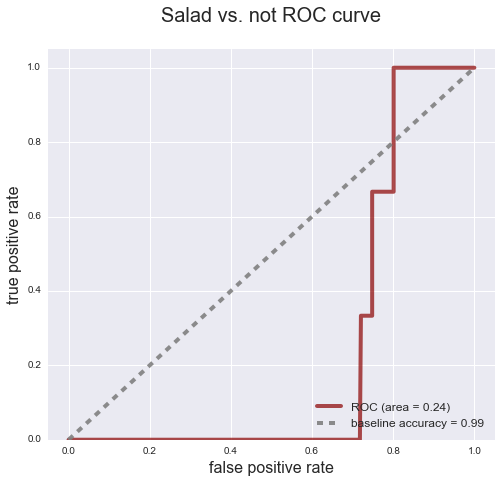

In [100]:
plot_roc(sal_lr, X_sal_test, y_sal_test, 'Salad')

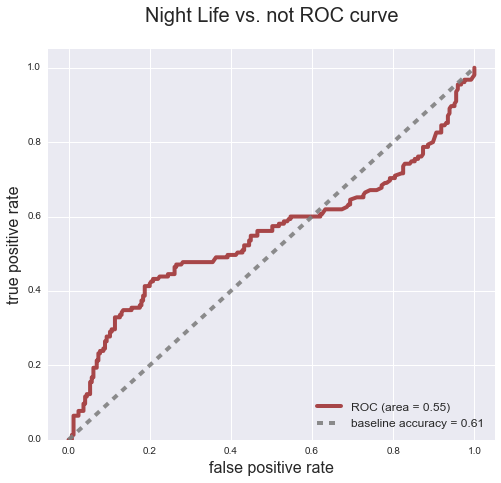

In [101]:
plot_roc(nig_lr, X_nig_test, y_nig_test, 'Night Life')

In [102]:
def calc_confusion_matrix(mod, X, y, margins=False):
    pred = pd.Series(mod.predict(X), name='Predicted')
    true = pd.Series(y, name='True')
    confusion = pd.crosstab(true, pred, margins=margins)
    return confusion

In [103]:
calc_confusion_matrix(nig_lr, X_nig_train, y_nig_train, margins=True)

Predicted,0,1,All
True,,,
0,333,19,352
1,204,44,248
All,537,63,600


In [104]:
calc_confusion_matrix(sal_lr, X_sal_train, y_sal_train, margins=True)

Predicted,0,All
True,,
0,597,597
1,3,3
All,600,600


In [105]:
from sklearn.metrics import (precision_recall_curve, average_precision_score, f1_score)

def plot_prauc(mod, X, y, varname):
    mod.fit(X, y)
    y_pp = mod.predict_proba(X)[:, 1]
    precision, recall, _ = precision_recall_curve(y, y_pp)
    avg_precision = average_precision_score(y, y_pp)
    
    fig, axr = plt.subplots(figsize=(8,7))

    axr.plot(recall, precision, label='PRAUC (area = %0.2f)' % avg_precision,
             color='steelblue', linewidth=4,
             alpha=0.7)

    axr.set_xlim([-0.05, 1.05])
    axr.set_ylim([0.0, 1.05])
    axr.set_xlabel('recall', fontsize=16)
    axr.set_ylabel('precision', fontsize=16)
    axr.set_title(varname+' vs. not PRAUC curve\n', fontsize=20)

    axr.legend(loc="upper right", fontsize=12)

    plt.show()

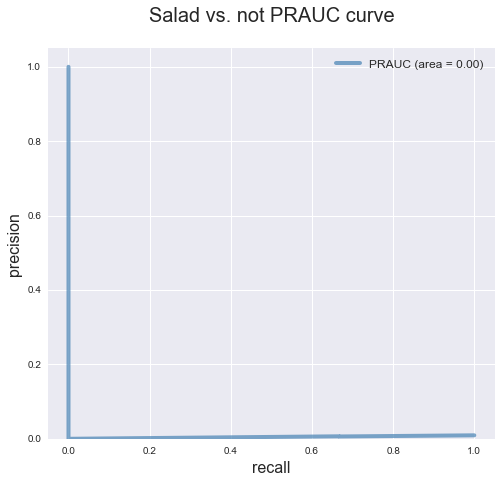

In [106]:
plot_prauc(sal_lr, X_sal_test, y_sal_test, 'Salad')

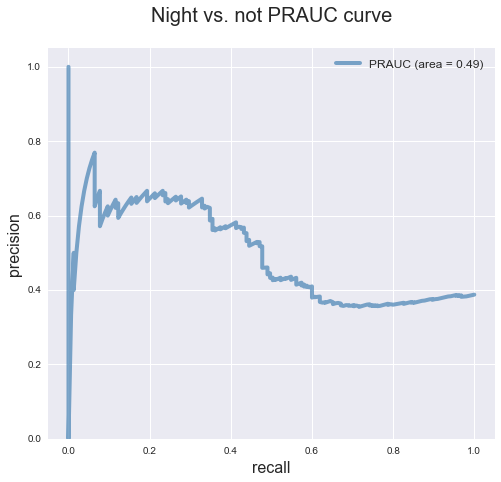

In [107]:
plot_prauc(nig_lr, X_nig_test, y_nig_test, 'Night')